In [1]:
### Function to compute uniform point spacing along span.
def computeUniform(nBladePoints,bladeLength):

    xBladePoints = np.zeros((nBladePoints,))
    ds = bladeLength/nBladePoints*np.ones((nBladePoints,))
    for i in range(nBladePoints):
        if (i == 0):
            xBladePoints[i] = 0.5*ds[i]
        else:
            xBladePoints[i] = xBladePoints[i-1] + ds[i]
    
    return xBladePoints,ds
            
            
            

In [2]:
### Function to compute chord-clustered spacing along span.
def computeClustered(nBladePoints,bladeLength,clusteringChordExponent,r_,c_,tol=1.0E-6,printConvergence=False):
    
    # Compute an initial uniform spacing with actuator points at centers of equal length actuator elements.
    xBladePoints,ds = computeUniform(nBladePoints,bladeLength)
    
    # Get the interpolated blade chord at each actuator location.
    c = np.interp(xBladePoints,r_,c_)
    
    # Enter a nonliner iterative solver to compute the actuator element sizes to be proportional to chord^p,
    # where p is some exponent on chord.  For the most part, we set this exponent to 1.
    eMag = 1.0E6
    n = 1
    if (printConvergence):
        print('iter #','residual')
        
    while (eMag > tol):
        alpha = bladeLength/np.sum(np.power(c,clusteringChordExponent))
        ds = alpha*np.power(c,clusteringChordExponent)
        x_ = np.copy(xBladePoints)
        for i in range(nBladePoints):
            if (i == 0):
                xBladePoints[i] = 0.5*ds[i]
            else:
                xBladePoints[i] = xBladePoints[i-1] + 0.5*ds[i-1] + 0.5*ds[i]
            
        c = np.interp(xBladePoints,r_,c_)
    
        e = x_ - xBladePoints
        eMag = np.sum(np.square(e))
    
        if (printConvergence):
            print(n,eMag)
            
        n = n+1
    
    # Return the actuator points; the actuator element lengths; alpha, a ratio of actuator element length to
    # chord length; number of iterations; and final iterative solver residual.
    return xBladePoints,ds,alpha,n,e
        
        

In [3]:
### Load necessary modules.

import numpy as np
import matplotlib.pyplot as plt




In [4]:
### User input.

epsilonScalingType = 'chord'       # Options are 'chord' or 'none'.  If 'chord', final 
                                   #    eps = chord*epsilonChordRatio.
epsilonChordRatio = 0.25           # If epsilonScalingType is 'chord', then this is eps/chord.
epsilon = 1.0                      # If epsilonScalingType is 'none', then this is the absolute eps.

bladeLength = 86.4                 # Overall blade length.
nBladePointsClusteredType = 'auto' # If 'auto', number of points will be calculate based on smoothnessRatio, if
                                   #    'none', the given number of points will be used.
nBladePointsUniformType = 'auto'   # If 'auto', number of points will be calculate based on smoothnessRatio, if 
                                   #    'none', the given number of points will be used.
nBladePointsClustered = 10         # Number of clustered blade points.  Will change is nBladePoints is 'auto'.
nBladePointsUniform = 10           # Number of uniform blade points.  Will change is nBladePoints is 'auto'.
smoothnessRatio = 0.85             # Ratio of epsilon to actuator element.  Dictates how smooth the overlapping
                                   #    body forces become.  A value of 0.85 seems most efficient.
clusteringChordExponent = 1.0      # For chord clustered spacing, the spacing is proportional to chord^n.  This 
                                   #    variable is n.


nPlotPoints = 1000                 # How many points is body force computed on.
yOffset = [0.0,0.25,0.5,0.75,1.0]  # List of offsets away from line to compute body force.
computeBodyForceBeyondTip = 0.01   # Percentage beyond tips to compute body force.

forcePerUnitLength = 1.0           # Force per unit length for visualizing body force.

bladeGeometryFile = '/scratch/mchurchf/equinor.FY22/DTU_10MW/DTU_10MW/BLADEGEO-DTU.dat'




Text(0, 0.5, 'chord (m)')

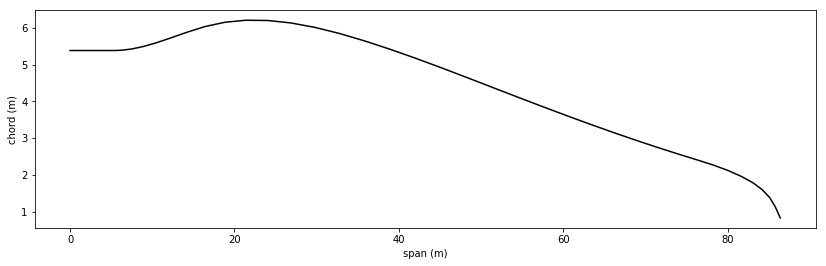

In [5]:
### Read the necessary blade geometry data.  This may have to be changed for different formats.  This is currently
#   set up for a simple OpenFAST input.

data = np.loadtxt(bladeGeometryFile,skiprows=6)
r_ = data[:,0]
c_ = data[:,5]

plt.figure(figsize=(14.0,4.0))
plt.plot(r_,c_,'k-')
plt.xlabel('span (m)')
plt.ylabel('chord (m)')




Number of clustered actuator points: 76


Text(0, 0.5, 'chord (m)')

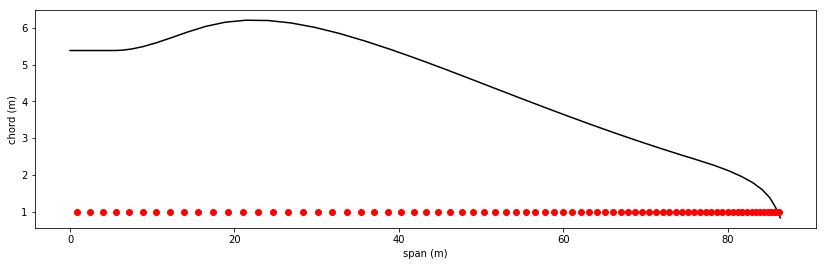

In [6]:
### Compute clustered blade point distribution.

# Initially compute the clustering based on a given number of points.
xBladePointsClustered,dsClustered,alpha,n,e = computeClustered(nBladePointsClustered,
                                                               bladeLength,
                                                               clusteringChordExponent,r_,c_,1.0E-6,False)

# If you selected nBladePointsClusteredType as 'auto', you want the code to find the minimum number of points 
# required to satisify some smoothnessRatio.  We find that a smoothness ratio of 0.85 will give the minimum points
# and still provide a smooth body force distribution.
if (nBladePointsClusteredType == 'auto'):
    
    # This is an iterative solver using the bisection method to converge on the number of actuator points required
    # to provide the desired smoothnessRatio.
    nL = 2
    nH = 1000
    while (nH-nL > 1):
        xL,dsL,alphaL,n,e = computeClustered(nL,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)
        xH,dsH,alphaH,n,e = computeClustered(nH,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)
    
        pL = np.max(epsilonChordRatio*np.interp(xL,r_,c_)/dsL)
        pH = np.max(epsilonChordRatio*np.interp(xH,r_,c_)/dsH)
    
        errL = np.abs(pL - smoothnessRatio)
        errH = np.abs(pH - smoothnessRatio)
    
        if (errL < errH):
            nH = int(np.round(0.5*(nL + nH)))
        else:
            nL = int(np.round(0.5*(nL + nH)))
        
        
    if (errL <= errH):
        nBladePointsClustered = nL
    else:
        nBladePointsClustered = nH
        
    xBladePointsClustered,dsClustered,alpha,n,e = computeClustered(nBladePointsClustered,
                                                                   bladeLength,
                                                                   clusteringChordExponent,r_,c_,1.0E-6,False)

    


# Get the final chord and absolute epsilon along the blade for chord clustered points.
chordClustered = np.interp(xBladePointsClustered,r_,c_)
epsilonClustered = epsilonChordRatio*chordClustered

print('Number of clustered actuator points:', nBladePointsClustered)


plt.figure(figsize=(14.0,4.0))
plt.plot(r_,c_,'k-')
plt.plot(xBladePointsClustered,np.ones((nBladePointsClustered,)),'ro')
plt.xlabel('span (m)')
plt.ylabel('chord (m)')




In [7]:
### Compute uniform blade point distribution.

# Initially compute spacing based on a given number of points. 
xBladePointsUniform,dsUniform = computeUniform(nBladePointsUniform,bladeLength)

        
# If you selected nBladePointsUniformType as 'auto', you want the code to find the minimum number of points 
# required to satisify some smoothnessRatio.  We find that a smoothness ratio of 0.85 will give the minimum points
# and still provide a smooth body force distribution.  For uniform spacing on a blade with variable chord,
# the ratio of spacing to chord varies, so a spacing will be chosen such that nowhere on the blade is the 
# smoothnessRatio exceeded.
nOld = nBladePointsUniform
minRatio = np.min(np.divide(epsilonChordRatio*np.interp(xBladePointsUniform,r_,c_),dsUniform))
scale = smoothnessRatio/minRatio
n = int(np.round(scale*nOld))
if (nBladePointsUniformType == 'auto'):
    while (np.abs(nOld - n) > 0):
        xBladePointsUniform,dsUniform = computeUniform(n,bladeLength)
        chordUniform = np.interp(xBladePointsUniform,r_,c_)
        epsilonUniform = epsilonChordRatio*chordUniform
        minRatio = np.min(np.divide(epsilonUniform,dsUniform))
        scale = smoothnessRatio/minRatio
        nOld = n
        n = int(np.round(scale*nOld))


nBladePointsUniform = n
chordUniform = np.interp(xBladePointsUniform,r_,c_)
epsilonUniform = epsilonChordRatio*chordUniform

print('Number of uniform actuator points:', nBladePointsUniform)




Number of uniform actuator points: 327


In [8]:
xPlotPoints = np.linspace(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength,nPlotPoints)

gUniform = np.zeros((nPlotPoints,))
gClustered = np.zeros((nPlotPoints,))

fUniform = []
fClustered = []

for m in range(len(yOffset)):   
    fUniform_ = np.zeros((nPlotPoints,))
    fClustered_ = np.zeros((nPlotPoints,))
    
    for i in range(nBladePointsUniform):
        dSqrUniform = np.square(xPlotPoints - xBladePointsUniform[i]) + np.square(yOffset[m])
    
        coeffUniform = (1.0/((epsilonUniform[i]**3) * (np.pi**1.5)))
    
        gUniform = coeffUniform * np.exp(-(dSqrUniform/np.square(epsilonUniform[i])))
    
        fUniform_ = fUniform_ + forcePerUnitLength*dsUniform[i]*gUniform
    
    for i in range(nBladePointsClustered):
        dSqrClustered = np.square(xPlotPoints - xBladePointsClustered[i]) + np.square(yOffset[m])
    
        coeffClustered = (1.0/((epsilonClustered[i]**3) * (np.pi**1.5)))
    
        gClustered = coeffClustered * np.exp(-(dSqrClustered/np.square(epsilonClustered[i])))
    
        fClustered_ = fClustered_ + forcePerUnitLength*dsClustered[i]*gClustered
        
    fUniform.append(fUniform_)
    fClustered.append(fClustered_)
    
    
    

Text(0, 0.5, 'body force')

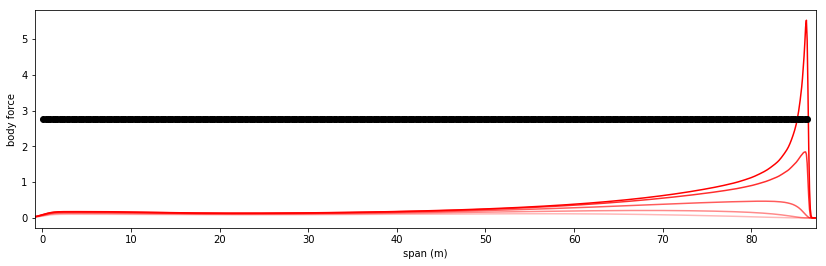

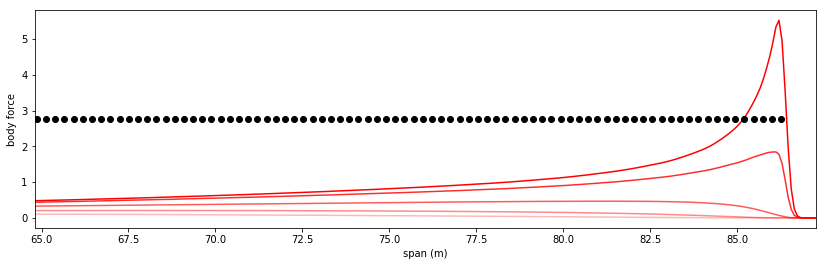

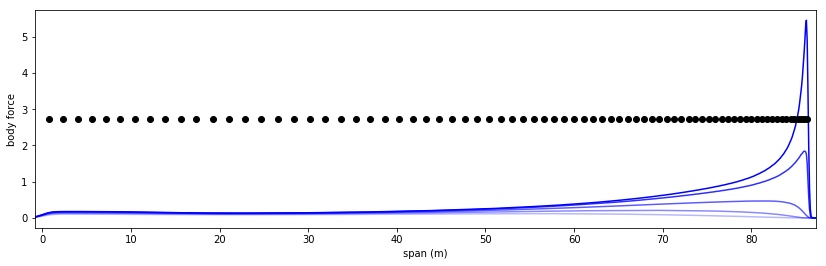

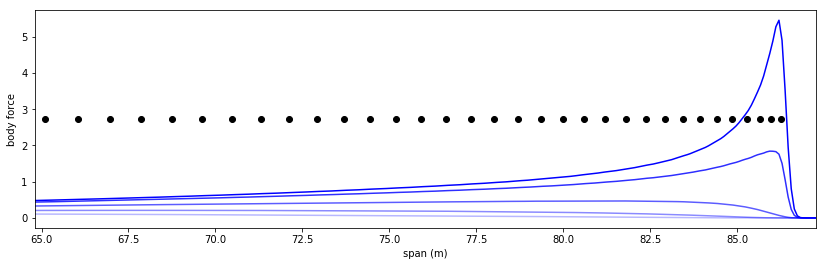

In [12]:
p = 0.5*(np.min(fUniform[0])+np.max(fUniform[0]))

plt.figure(0,figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fUniform[m],'r-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsUniform,p*np.ones(nBladePointsUniform,),'ko')
plt.xlim(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')

plt.figure(1,figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fUniform[m],'r-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsUniform,p*np.ones(nBladePointsUniform,),'ko')
plt.xlim(0.75*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')





p = 0.5*(np.min(fClustered[0])+np.max(fClustered[0]))

plt.figure(figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fClustered[m],'b-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsClustered,p*np.ones(nBladePointsClustered,),'ko')
plt.xlim(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')

plt.figure(figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fClustered[m],'b-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsClustered,p*np.ones(nBladePointsClustered,),'ko')
plt.xlim(0.75*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')




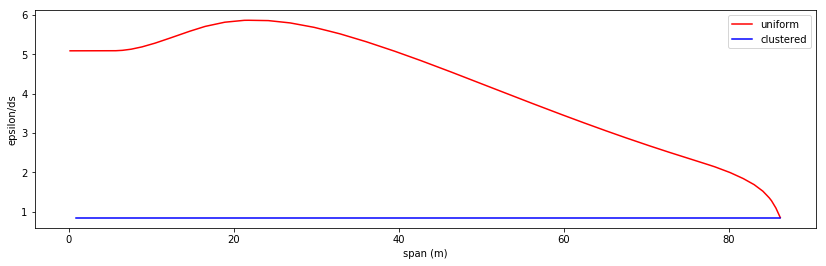

In [13]:
plt.figure(figsize=(14.0,4.0))
plt.plot(xBladePointsUniform,np.divide(epsilonUniform,dsUniform),'r-')
plt.plot(xBladePointsClustered,np.divide(epsilonClustered,dsClustered),'b-')
plt.xlabel('span (m)')
plt.ylabel('epsilon/ds')
plt.legend(['uniform','clustered'])




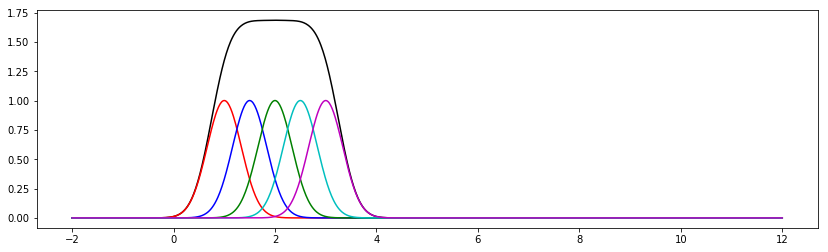

In [11]:
x = np.linspace(-2.0,12.0,1000)
x1 = 1.0
x2 = 1.5
x3 = 2.0
x4 = 2.5
x5 = 3.0
eps = 0.475
f1 = np.exp(-np.square((x-x1)/eps))
f2 = np.exp(-np.square((x-x2)/eps))
f3 = np.exp(-np.square((x-x3)/eps))
f4 = np.exp(-np.square((x-x4)/eps))
f5 = np.exp(-np.square((x-x5)/eps))
f = f1 + f2 + f3 + f4 + f5
plt.figure(figsize=(14,4))
plt.plot(x,f,'k-')
plt.plot(x,f1,'r-')
plt.plot(x,f2,'b-')
plt.plot(x,f3,'g-')
plt.plot(x,f4,'c-')
plt.plot(x,f5,'m-')
#plt.ylim((1.5,1.65))


